In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 25.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 612kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.56MB/s]


In [ ]:
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False
)


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [19]:
def loss_with_kl(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
latent_dim = 20
model = VAE(latent_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 10
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for data, _ in train_loader:
        data = data.view(-1, 784).to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 164.9310
Epoch [2/10], Loss: 121.8895
Epoch [3/10], Loss: 114.9508
Epoch [4/10], Loss: 112.0012
Epoch [5/10], Loss: 110.2766
Epoch [6/10], Loss: 109.0455
Epoch [7/10], Loss: 108.2499
Epoch [8/10], Loss: 107.6011
Epoch [9/10], Loss: 107.0986
Epoch [10/10], Loss: 106.6268


In [20]:
model_with_kl = VAE(latent_dim).to(device)
optimizer_with_kl = optim.Adam(model_with_kl.parameters(), lr=1e-3)

losses_with_kl = []

for epoch in range(epochs):
    total_loss = 0
    model_with_kl.train()

    for data, _ in train_loader:
        data = data.view(-1, 784).to(device)

        optimizer_with_kl.zero_grad()
        recon, mu, logvar = model_with_kl(data)

        loss = loss_with_kl(recon, data, mu, logvar)
        loss.backward()
        optimizer_with_kl.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    losses_with_kl.append(avg_loss)
    print(f"[WITH KL] Epoch {epoch+1}, Loss: {avg_loss:.4f}")


[WITH KL] Epoch 1, Loss: 165.1421
[WITH KL] Epoch 2, Loss: 121.8313
[WITH KL] Epoch 3, Loss: 114.6892
[WITH KL] Epoch 4, Loss: 111.6357
[WITH KL] Epoch 5, Loss: 109.9059
[WITH KL] Epoch 6, Loss: 108.6999
[WITH KL] Epoch 7, Loss: 107.9206
[WITH KL] Epoch 8, Loss: 107.2443
[WITH KL] Epoch 9, Loss: 106.7086
[WITH KL] Epoch 10, Loss: 106.3363


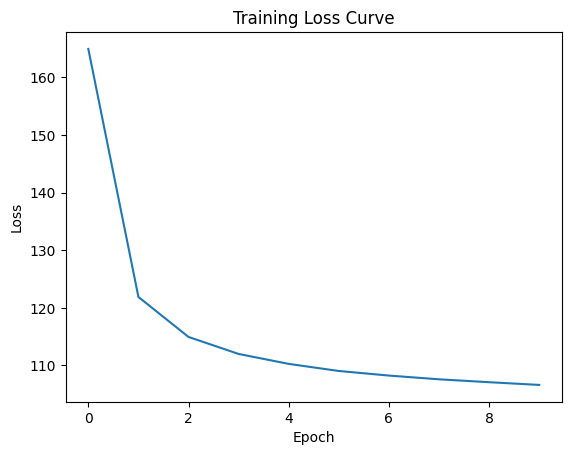

In [ ]:
plt.plot(train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# **WITH KL- WITH IMAGES**

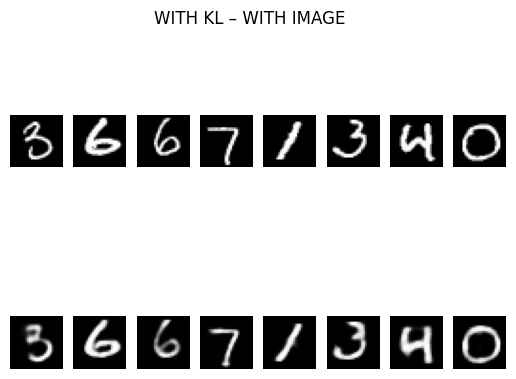

In [21]:
model_with_kl.eval()

with torch.no_grad():
    recon_with_kl, _, _ = model_with_kl(data)

for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(data[i].cpu().view(28,28), cmap="gray")
    plt.axis("off")

    plt.subplot(2,8,i+9)
    plt.imshow(recon_with_kl[i].cpu().view(28,28), cmap="gray")
    plt.axis("off")

plt.suptitle("WITH KL – WITH IMAGE")
plt.show()


# **WITH KL- WITHOUT IMAGE**

In [22]:
print("WITH KL – WITHOUT IMAGE")
print(recon_with_kl[0])
print("Shape:", recon_with_kl.shape)
print("Mean:", recon_with_kl.mean().item())
print("Std:", recon_with_kl.std().item())


WITH KL – WITHOUT IMAGE
tensor([1.0863e-05, 1.1527e-05, 8.3541e-06, 9.1676e-06, 1.6155e-05, 8.6151e-06,
        1.0043e-05, 1.4045e-05, 1.0475e-05, 1.3823e-05, 1.6913e-05, 1.0462e-05,
        5.5787e-05, 3.7375e-05, 7.4821e-06, 1.5527e-05, 5.8053e-06, 7.9471e-06,
        1.0877e-05, 8.3834e-06, 1.6411e-05, 1.3642e-05, 1.5606e-05, 7.2838e-06,
        7.7804e-06, 1.6733e-05, 9.9383e-06, 1.4143e-05, 1.0072e-05, 9.8056e-06,
        1.5989e-05, 1.5313e-05, 2.3243e-05, 2.0465e-05, 2.8910e-05, 7.7653e-06,
        4.3748e-06, 1.8671e-06, 4.0621e-07, 2.6479e-07, 5.8710e-07, 2.0477e-07,
        2.0845e-07, 1.3457e-07, 1.8054e-07, 7.3958e-08, 7.5203e-08, 2.7258e-07,
        6.8227e-07, 3.8338e-06, 7.4324e-06, 4.5104e-05, 1.8384e-05, 1.4080e-05,
        8.6510e-06, 1.1273e-05, 1.4636e-05, 1.5758e-05, 2.6684e-05, 1.7421e-05,
        1.0373e-04, 9.3112e-05, 4.3020e-05, 2.1722e-05, 1.0902e-05, 1.8388e-05,
        3.3679e-05, 6.6943e-05, 7.6998e-05, 3.3330e-05, 5.3178e-05, 1.2482e-04,
        7.0489e-